# Setup environment

In [1]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    base_folder = Path('/content/drive/MyDrive/')
    data_folder = Path('/content')

    !pip install pytorch-lightning==2.0.9 -qq

    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq

else:
    base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor')
    data_folder = Path('/home/harpreet/data')


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 31.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00


In [2]:
custom_function_folder = base_folder/'data/custom-functions/fall_2023'
sys.path.append(str(custom_function_folder))
model_folder = base_folder/'data/models/dl_fall_2023/dog_breed/oct-17'
model_folder.mkdir(parents=True, exist_ok=True)
project_folder = base_folder/'data/imagenette2'
kaggle_api_folder = base_folder/'data/.kaggle'

In [3]:
# import Libraries
import yaml

import torch
import torch.nn as nn
import torchmetrics
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import wandb
import gc

from data_module_imagenette2 import ImagenetteDataModule
from multiclass_lightning_module_v0 import MultiClassLightningModule
from model_two_layer_bn import TwoLayerMLPBN
from shared_utils import  plot_losses_acc

In [4]:
!pip show pytorch-lightning

Name: pytorch-lightning
Version: 2.0.9
Summary: PyTorch Lightning is the lightweight PyTorch wrapper for ML researchers. Scale your models. Write less boilerplate.
Home-page: https://github.com/Lightning-AI/lightning
Author: Lightning AI et al.
Author-email: pytorch@lightning.ai
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: fsspec, lightning-utilities, numpy, packaging, PyYAML, torch, torchmetrics, tqdm, typing-extensions
Required-by: 


In [5]:
nn.Conv2d??

# Model

In [6]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.main_path(x)
        residual = self.downsample(residual)
        out += residual
        out = nn.ReLU(inplace=True)(out)
        return out

class SimpleResNet(nn.Module):
    def __init__(self, num_classes=120):
        super(SimpleResNet, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3),  # Output: 16x250x188
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),      # Output: 16x125x94
            ResidualBlock(16, 32, stride=2),                       # Output: 32x63x47
            ResidualBlock(32, 64, stride=2),                       # Output: 64x32x24
            ResidualBlock(64, 128, stride=2),                      # Output: 128x16x12
            ResidualBlock(128, 256, stride=2),                     # Output: 256x8x6
            nn.Conv2d(256, num_classes, kernel_size=1),            # 1x1 convolution to map to num_classes
            nn.AdaptiveAvgPool2d((1, 1)),                          # Global Average Pooling, Output: num_classes x 1 x 1
        )

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)  # Flatten the output to [batch_size x num_classes]
        return x

In [7]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

model = SimpleResNet(num_classes=120)
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Total parameters: 1256120
Trainable parameters: 1256120


# Function to load the model

In [8]:
# Function to load the model
def load_model(model_config):
    model = SimpleResNet(model_config['num_classes'])
    return model


# Functions for Transformations

In [9]:
def get_train_transforms(resize_height, resize_width, normalize_mean, normalize_std):

    return transforms.Compose(
        [
            transforms.Resize((resize_height, resize_width)),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ]
    )

def get_test_transforms(resize_height, resize_width, normalize_mean, normalize_std):

    return transforms.Compose(
        [
            transforms.Resize((resize_height, resize_width)),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ]
    )


# Function to load DataModule

In [10]:
def load_datamodule(config, data_folder):
    # Fetch the correct transform function based on config and pass the appropriate arguments
    train_transform = get_train_transforms(**config['train_transform'])
    test_transform = get_test_transforms(**config['test_transform'])
    dm = ImagenetteDataModule(
        data_dir=data_folder,
        train_transform=train_transform,
        test_transform=test_transform,
        **config['data_module']
    )
    return dm



# Function to load LightningModule

In [11]:
def load_lightning_module(config, model):
    optimizer_cls = eval(config['optimizer_cls'])
    loss_fn = eval(config['loss_fn'])()  # directly instantiate the loss function
    metric_cls = eval(config['metric_cls'])

    # If scheduler is defined, convert its string to class as well
    if config.get('scheduler_cls'):
        scheduler_cls = eval(config['scheduler_cls'])
        scheduler_options = config['scheduler_options']
        scheduler_params =   config['scheduler_params']
    else:
        scheduler_cls = None

    lightning_module = MultiClassLightningModule(model=model,
                                                 optimizer_cls=optimizer_cls,
                                                 loss_fn=loss_fn,
                                                 metric_cls=metric_cls,
                                                 scheduler_cls=scheduler_cls,
                                                 scheduler_options=scheduler_options,
                                                 scheduler_params=scheduler_params,
                                                 **config['others']
)
    return lightning_module


# Function to load the Trainer

In [12]:
def load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=False, checkpointing=True, early_stopping=False):

    lr_monitor = LearningRateMonitor(**cl_config['lr_monitor'])
    callbacks = [lr_monitor]
    if checkpointing:
        model_checkpoint_callback = ModelCheckpoint(dirpath=model_folder/cl_config['log_dir'],
                                                **cl_config['model_checkpoint'])
        callbacks.append(model_checkpoint_callback)

    if early_stopping:
        early_stop_callback = EarlyStopping(**cl_config['early_stopping'] )
        callbacks.append(early_stop_callback)

    if logging:
        # For WandB logger:
        wandb_logger = WandbLogger(project=cl_config['wandb']['project'], name=cl_config['wandb']['name'], save_dir=model_folder/cl_config['log_dir'])
        wandb_logger.experiment.config.update({'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})
        wandb_logger.watch(model)

        # For CSV logger:
        csv_logger = CSVLogger(save_dir=model_folder/cl_config['log_dir'], name=cl_config['csv']['name'])
        csv_logger.log_hyperparams(params={'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})

        trainer = pl.Trainer(callbacks=callbacks,
                            logger=[csv_logger, wandb_logger],
                            **trainer_config)
    else:
        trainer = pl.Trainer(callbacks=callbacks,
                            **trainer_config
                )
    return trainer



# Function to load components

In [13]:
def load_components(model_config, data_module_config, lightning_module_config, data_folder, trainer_config,
cl_config, batch_size,logging=False, checkpointing=True, early_stopping=False):

    # Load the model
    model = load_model(model_config)

    # Load the data module
    dm = load_datamodule(data_module_config, data_folder)

    # Load the lightning module
    lightning_module = load_lightning_module(lightning_module_config, model)

    # Load the trainer
    trainer = load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=logging,
                           checkpointing=checkpointing, early_stopping=early_stopping)

    return model, dm, lightning_module, trainer

In [14]:
def load_yaml(filepath):
    with open(filepath, 'r') as file:
        return yaml.safe_load(file)

# Function to Load config files

In [15]:
# Load configurations from YAML files
def load_all_configs():
    model_config = load_yaml(project_folder/'model_config.yaml')
    data_module_config = load_yaml(project_folder/'data_module_config.yaml')
    lightning_module_config = load_yaml(project_folder/'lightning_module_config.yaml')
    cl_config = load_yaml(project_folder/'callbacks_loggers_config.yaml')
    trainer_config = load_yaml(project_folder/'trainer_config.yaml')

    return model_config, data_module_config, lightning_module_config, cl_config, trainer_config



# Function to free memory

In [16]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

# Run One training and validation batch to check bugs

In [17]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['fast_dev_run']=True
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | SimpleResNet       | 1.2 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total pa

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.09 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


Train_Loss: 2.37, Train_Metric: 0.08


# Find Learning Rate

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1: Val_Loss: 2.30, Val_Metric: 0.10 | 

Finding best initial lr:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.0010000000000000002
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_554a65bf-6e74-4e14-9705-07a873a6e325.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_554a65bf-6e74-4e14-9705-07a873a6e325.ckpt


Train_Loss: 2.20, Train_Metric: 0.23
0.0010000000000000002


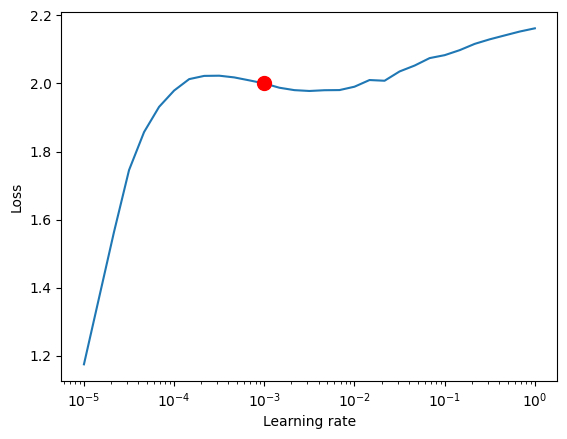

In [18]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['max_epochs']=5
data_module_config['data_module']['batch_size']=128

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup()
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(lightning_module, datamodule=dm, min_lr=1e-5, max_lr=1, num_training=30, mode='exponential')
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()
print(new_lr)


# Overfit Small Subset

In [19]:
# Load components

free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
data_module_config['data_module']['batch_size']=128
trainer_config['overfit_batches']=1
lightning_module_config['others']['learning_rate']=0.005
trainer_config['max_epochs']=3
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup()
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | SimpleResNet       | 1.2 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 |

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.12 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:262: UserWarning: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.33, Val_Metric: 0.10 | Train_Loss: 2.49, Train_Metric: 0.00


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 2.32, Val_Metric: 0.09 | Train_Loss: 1.12, Train_Metric: 1.00


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 2.78, Val_Metric: 0.10 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Train_Loss: 0.16, Train_Metric: 1.00


# Regularization -I
- Early stopping with a patience of 5, total epochs = 50
- Gradient Clipping
- Weight Deacay of 1
- Reduce Learning rate on plateau
- Use 50% of train/val data

INFO:lightning_fabric.utilities.seed:Global seed set to 42


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/oct-17/logs exists and 

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.10 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 4.24, Val_Metric: 0.18 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 4.242


Train_Loss: 1.98, Train_Metric: 0.30


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 1.67, Val_Metric: 0.44 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 2.571 >= min_delta = 0.0. New best score: 1.671


Train_Loss: 1.67, Train_Metric: 0.43


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 1.70, Val_Metric: 0.44 | Train_Loss: 1.51, Train_Metric: 0.50
Epoch 00003: reducing learning rate of group 0 to 2.5000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 1.45, Val_Metric: 0.52 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.217 >= min_delta = 0.0. New best score: 1.454


Train_Loss: 1.32, Train_Metric: 0.56


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 1.41, Val_Metric: 0.53 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 1.405


Train_Loss: 1.19, Train_Metric: 0.61


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 1.27, Val_Metric: 0.60 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.134 >= min_delta = 0.0. New best score: 1.271


Train_Loss: 1.07, Train_Metric: 0.65


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 1.27, Val_Metric: 0.59 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.268


Train_Loss: 1.02, Train_Metric: 0.67


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 1.42, Val_Metric: 0.54 | Train_Loss: 0.94, Train_Metric: 0.70
Epoch 00008: reducing learning rate of group 0 to 1.2500e-03.


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 1.01, Val_Metric: 0.68 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.257 >= min_delta = 0.0. New best score: 1.012


Train_Loss: 0.79, Train_Metric: 0.75


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 1.11, Val_Metric: 0.66 | Train_Loss: 0.71, Train_Metric: 0.77
Epoch 00010: reducing learning rate of group 0 to 6.2500e-04.


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.89, Val_Metric: 0.70 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.121 >= min_delta = 0.0. New best score: 0.891


Train_Loss: 0.63, Train_Metric: 0.80


Validation: 0it [00:00, ?it/s]

Epoch 12: Val_Loss: 0.91, Val_Metric: 0.71 | Train_Loss: 0.57, Train_Metric: 0.82
Epoch 00012: reducing learning rate of group 0 to 3.1250e-04.


Validation: 0it [00:00, ?it/s]

Epoch 13: Val_Loss: 0.87, Val_Metric: 0.73 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.866


Train_Loss: 0.51, Train_Metric: 0.84


Validation: 0it [00:00, ?it/s]

Epoch 14: Val_Loss: 0.86, Val_Metric: 0.72 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.860


Train_Loss: 0.48, Train_Metric: 0.85


Validation: 0it [00:00, ?it/s]

Epoch 15: Val_Loss: 0.87, Val_Metric: 0.72 | Train_Loss: 0.46, Train_Metric: 0.86
Epoch 00015: reducing learning rate of group 0 to 1.5625e-04.


Validation: 0it [00:00, ?it/s]

Epoch 16: Val_Loss: 0.81, Val_Metric: 0.73 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.813


Train_Loss: 0.42, Train_Metric: 0.87


Validation: 0it [00:00, ?it/s]

Epoch 17: Val_Loss: 0.82, Val_Metric: 0.74 | Train_Loss: 0.40, Train_Metric: 0.88
Epoch 00017: reducing learning rate of group 0 to 7.8125e-05.


Validation: 0it [00:00, ?it/s]

Epoch 18: Val_Loss: 0.80, Val_Metric: 0.74 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.796


Train_Loss: 0.38, Train_Metric: 0.89


Validation: 0it [00:00, ?it/s]

Epoch 19: Val_Loss: 0.78, Val_Metric: 0.74 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.779


Train_Loss: 0.37, Train_Metric: 0.90


Validation: 0it [00:00, ?it/s]

Epoch 20: Val_Loss: 0.78, Val_Metric: 0.75 | Train_Loss: 0.37, Train_Metric: 0.90
Epoch 00020: reducing learning rate of group 0 to 3.9063e-05.


Validation: 0it [00:00, ?it/s]

Epoch 21: Val_Loss: 0.78, Val_Metric: 0.74 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.778


Train_Loss: 0.36, Train_Metric: 0.90


Validation: 0it [00:00, ?it/s]

Epoch 22: Val_Loss: 0.77, Val_Metric: 0.75 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.772


Train_Loss: 0.35, Train_Metric: 0.90


Validation: 0it [00:00, ?it/s]

Epoch 23: Val_Loss: 0.78, Val_Metric: 0.74 | Train_Loss: 0.34, Train_Metric: 0.91
Epoch 00023: reducing learning rate of group 0 to 1.9531e-05.


Validation: 0it [00:00, ?it/s]

Epoch 24: Val_Loss: 0.77, Val_Metric: 0.75 | Train_Loss: 0.34, Train_Metric: 0.91
Epoch 00024: reducing learning rate of group 0 to 9.7656e-06.


Validation: 0it [00:00, ?it/s]

Epoch 25: Val_Loss: 0.77, Val_Metric: 0.75 | Train_Loss: 0.33, Train_Metric: 0.91
Epoch 00025: reducing learning rate of group 0 to 4.8828e-06.


Validation: 0it [00:00, ?it/s]

Epoch 26: Val_Loss: 0.78, Val_Metric: 0.75 | Train_Loss: 0.34, Train_Metric: 0.90
Epoch 00026: reducing learning rate of group 0 to 2.4414e-06.


Validation: 0it [00:00, ?it/s]

Epoch 27: Val_Loss: 0.77, Val_Metric: 0.74 | 

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 0.772. Signaling Trainer to stop.


Train_Loss: 0.34, Train_Metric: 0.91
Epoch 00027: reducing learning rate of group 0 to 1.2207e-06.


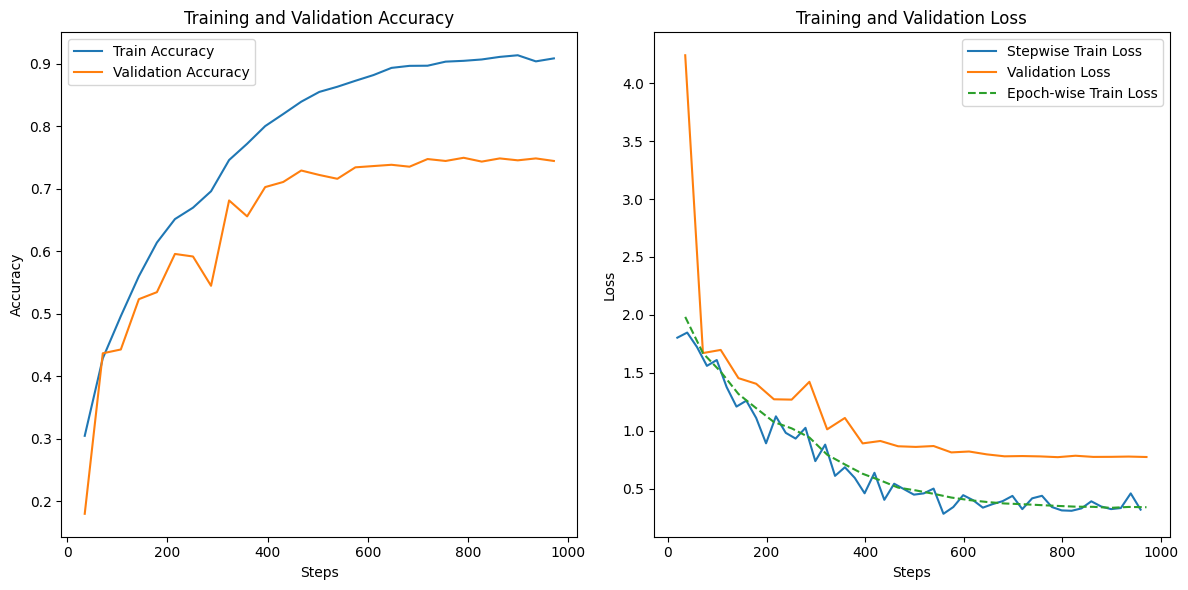

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/oct-17/logs/epoch=21-step=792-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/oct-17/logs/epoch=21-step=792-v1.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Epoch 28: Val_Loss: 0.33, Val_Metric: 0.92 | 

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/oct-17/logs/epoch=21-step=792-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/oct-17/logs/epoch=21-step=792-v1.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 28: Val_Loss: 0.77, Val_Metric: 0.75 | Train Accuracy: 91.78
Validation Accuracy: 74.95


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
lr-AdamW,███▄▄▄▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▇▆▅▅▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,██▇▇▇▅▅▅▄▅▄▄▃▄▂▂▂▃▂▂▂▂▂▁▁▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁
train_metric,▁▂▃▄▅▅▅▅▆▆▇▇▇▇▇████████████
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂
val_metric,▁▃▃▄▄▅▅▄▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆█▆
epoch,27
lr-AdamW,0.0
train_loss_epoch,0.33956


In [20]:
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# trainer_config
trainer_config['max_epochs']=50
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=20

# lightning module config
lightning_module_config['others']['optimizer_params']['weight_decay']=0.1
lightning_module_config['others']['learning_rate']=0.005
lightning_module_config['scheduler_cls']='torch.optim.lr_scheduler.ReduceLROnPlateau'
lightning_module_config['scheduler_params']= {'mode': 'min', 'patience': 0, 'factor': 0.5, 'verbose': True}
lightning_module_config['scheduler_options']= {'monitor': 'val_loss', 'interval': 'epoch', 'frequency': 1}

# logging
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='imagenette2_multiclass_CNN'
cl_config['wandb']['name']='simple_cnn_exp1'

# Data Module
data_module_config['data_module']['batch_size']=128
data_module_config['data_module']['small_subset']=True
data_module_config['data_module']['num_samples_small']=0.5

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=True)
dm.setup()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()